<a href="https://www.kaggle.com/nurbekserzhanov/dota-2-organized-data-for-prediction-of-winner?scriptVersionId=86259282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dota-2-matches/players.csv
/kaggle/input/dota-2-matches/ability_upgrades.csv
/kaggle/input/dota-2-matches/test_player.csv
/kaggle/input/dota-2-matches/match_outcomes.csv
/kaggle/input/dota-2-matches/teamfights_players.csv
/kaggle/input/dota-2-matches/chat.csv
/kaggle/input/dota-2-matches/purchase_log.csv
/kaggle/input/dota-2-matches/test_labels.csv
/kaggle/input/dota-2-matches/ability_ids.csv
/kaggle/input/dota-2-matches/item_ids.csv
/kaggle/input/dota-2-matches/player_time.csv
/kaggle/input/dota-2-matches/patch_dates.csv
/kaggle/input/dota-2-matches/yasp_sample.json
/kaggle/input/dota-2-matches/match.csv
/kaggle/input/dota-2-matches/player_ratings.csv
/kaggle/input/dota-2-matches/hero_names.csv
/kaggle/input/dota-2-matches/cluster_regions.csv
/kaggle/input/dota-2-matches/teamfights.csv
/kaggle/input/dota-2-matches/objectives.csv


In [2]:
data_players=pd.read_csv('/kaggle/input/dota-2-matches/players.csv')
data_players.head()
data_matches=pd.read_csv('/kaggle/input/dota-2-matches/match.csv')
data_matches.head()
data_teamfights=pd.read_csv('/kaggle/input/dota-2-matches/teamfights.csv')
data_teamfights.head()



,match_id,start,end,last_death,deaths
0,0,220,252,237,3
1,0,429,475,460,3
2,0,900,936,921,3
3,0,1284,1328,1313,3
4,0,1614,1666,1651,5


In [3]:
#Grouping new data frame by match_id and collection all heroes together than split them by team
import time
start_time = time.time()


dire_data=data_players.groupby('match_id')['hero_id'].apply(list)
def divide_by_team(df,new_df):
    for j in range(df.shape[0]):
        new_r=list()
        for i in range(5):
            new_r.append(df[j].pop(df[j].index(df[j][0])))
        dictionnar={"Radiant_team":new_r}
        new_df=new_df.append(dictionnar,ignore_index=True) 
    return new_df


radiant_data = pd.DataFrame()
radiant_data=divide_by_team(dire_data,radiant_data)#--- 86.03843569755554 seconds ---

print("--- %s seconds ---" % (time.time() - start_time))#136.3190200328827 sec for split method

--- 83.7157735824585 seconds ---


In [4]:
#Adding the data into data_matches and dropping the useless columns
data_matches['Radiant_team']=radiant_data
data_matches['Dire_team']=dire_data
data_matches=data_matches.drop(columns=['start_time','duration','game_mode','positive_votes','negative_votes','cluster'])
data_matches.columns


Index(['match_id', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_dire', 'barracks_status_radiant', 'first_blood_time',
       'radiant_win', 'Radiant_team', 'Dire_team'],
      dtype='object')

In [5]:
#Adding the mean_values of features which would be grouped by match_id
def adding_mean_values_of_diff_features_by_team(df,groupby,features,new_df):
    for i in range(len(features)):
        dire_data=df.groupby(groupby)[features[i]].apply(list)
        radiant_data=pd.DataFrame()
        radiant_data=divide_by_team(dire_data,radiant_data)
        radiant_data=radiant_data['Radiant_team'].apply(lambda x : sum(x)/len(x))
        dire_data=dire_data.apply(lambda x :sum(x)/len(x))
        new_df[features[i]+'_radiant']=radiant_data
        new_df[features[i]+'_dire']=dire_data
    return new_df

In [6]:
features=['gold_spent','gold_per_min','xp_per_min','kills','deaths','tower_damage','hero_damage']
data_matches=adding_mean_values_of_diff_features_by_team(data_players,'match_id',features,data_matches)
print(data_matches.head())

   match_id  tower_status_radiant  tower_status_dire  barracks_status_dire  \
0         0                  1982                  4                     3   
1         1                     0               1846                    63   
2         2                   256               1972                    63   
3         3                     4               1924                    51   
4         4                  2047                  0                     0   

   barracks_status_radiant  first_blood_time  radiant_win  \
0                       63                 1         True   
1                        0               221        False   
2                       48               190        False   
3                        3                40        False   
4                       63                58         True   

           Radiant_team               Dire_team  gold_spent_radiant  ...  \
0  [86, 51, 83, 11, 67]   [106, 102, 46, 7, 73]             17449.0  ...   
1   [7, 82, 

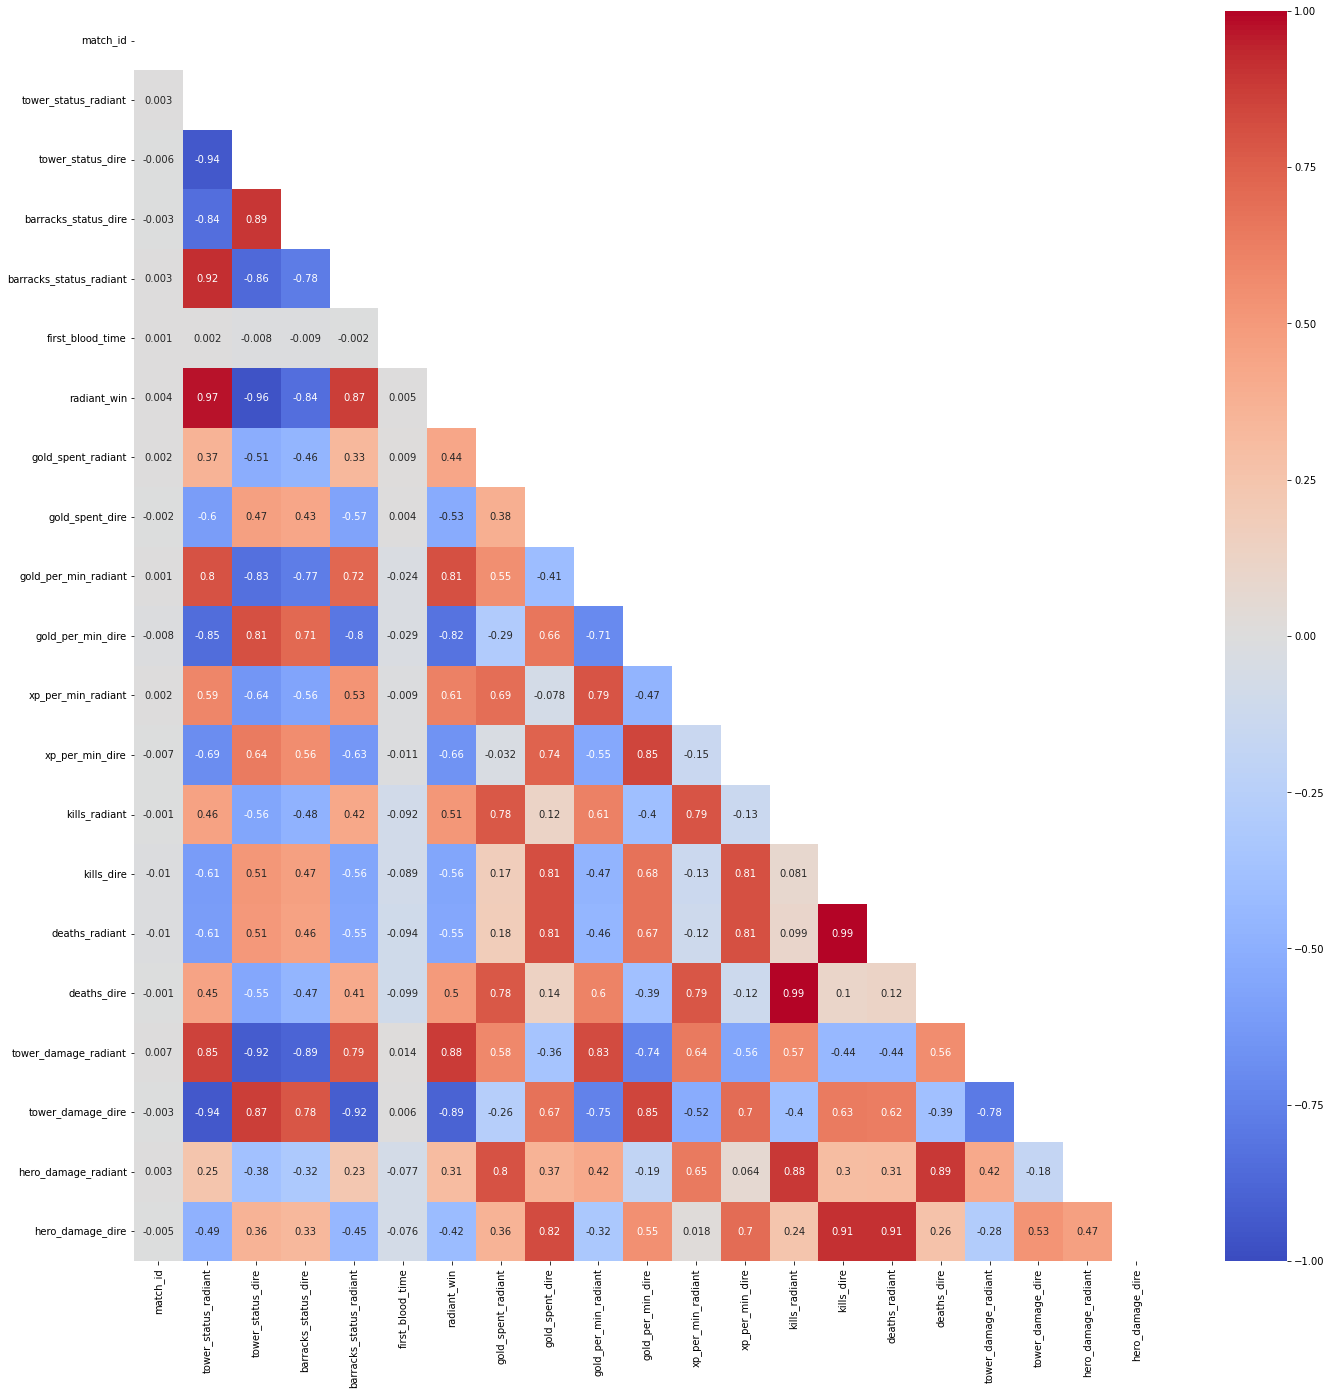

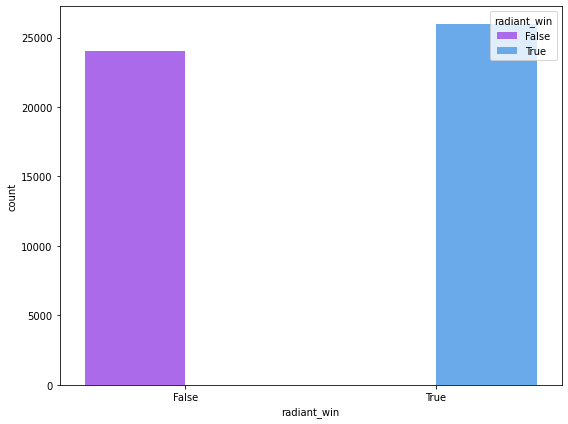

In [7]:
#Lets see the correlation between values and hist of wins
import matplotlib.pyplot as plt
import seaborn as sns
def corr_heatmap(df, digits=3, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Args:
        df (DataFrame) : DataFrame with features to check multicollinearity on.
        digits (int) : Number of decimal places to display
        cmap (str) : Colormap to display correlation range.

    Returns:
        fig : Matplotlib Figure
        ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    
    
    mask[np.triu_indices_from(mask)] = True
    

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax
corr_heatmap(data_matches)
fig, ax = plt.subplots(figsize=(8,6))
# sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1',bins=(2), kde=False)
sns.countplot(x='radiant_win', data=data_matches, hue='radiant_win', palette='cool_r')

# Save as image
plt.tight_layout()


In [8]:
from matplotlib.gridspec import GridSpec
def visual_eda(df, target, col):
    """
    Plots a histogram + KDE, boxplot, and scatter plot with linear regression 
    line of the specified column. Use to visualize shape of data, outliers, 
    and check column's correlation with target variable.

    Args:
        df (DataFrame) : DataFrame containing column to plot
        target (str) : Name of target variable.
        col (str) : Name of the column to plot.

    Returns:
        fig : Matplotlib Figure
        gs : Matplotlib GridSpec
    """
    # Create copy variables of df and col
    data = df[col].copy()
    name = col

    # Calc mean and mean
    median = data.median()
    mean = data.mean()
    
    
    # Create gridspec for plots
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])

    # Plot distribution 
    sns.histplot(data,alpha=0.5,stat='density',ax=ax0)
    sns.kdeplot(data,color='green',label='KDE',ax=ax0)
    ax0.set(ylabel='Density',title=name)
    ax0.set_title(F"Distribution of {name}")
    ax0.axvline(median,label=f'median={median:,}',color='black')
    ax0.axvline(mean,label=f'mean={mean:,}',color='black',ls=':')
    ax0.legend()

    # Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(F"Box Plot of {name}")

    # Plot Scatterplot to illustrate linearity
    sns.regplot(data=df, x=col, y=target, line_kws={"color": "red"}, ax=ax2)
    ax2.set_title(F"Scatter Plot of {name}")

    # Tweak Layout & Display
    fig.tight_layout()
   
    return fig, gs

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


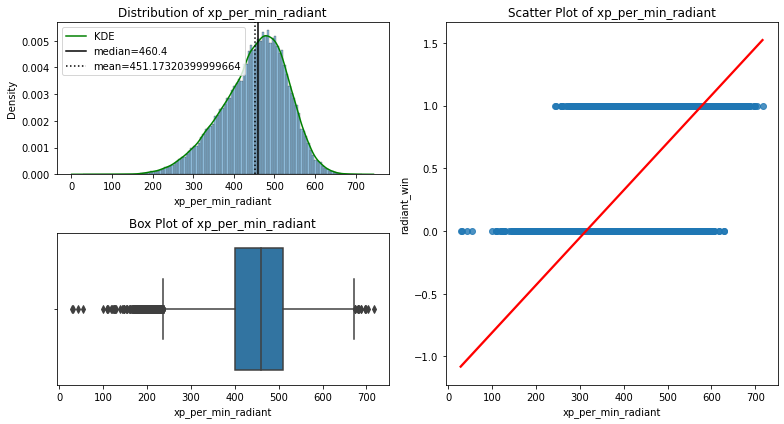

In [9]:
visual_eda(data_matches, 'radiant_win', 'xp_per_min_radiant');